In [1]:
import numpy as np
import pickle
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
from tqdm import tqdm as tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
cd drive/MyDrive/personal_projects/END_CAPSTONE/

[Errno 2] No such file or directory: 'drive/MyDrive/personal_projects/END_CAPSTONE/'
/media/tensor/EXTDRIVE/personal/capstone


In [4]:
!ls

 11777217
'clean dataset.ipynb'
 clean_python_dataset_final.pkl
 clean_python_dataset.pkl
 dataset_preprocessing.ipynb
 english_python_data.py
 english_python_data.txt
 explore_dataset.ipynb
'explore dataset recent.ipynb'
 glove_embs_training_trails_test1.ipynb
 Load_test_python_embedding.ipynb
 make_dataset.py
 pygments_data_tokens.pkl
 python_corpus_tokens_clean_small.pkl
 python_corpus_tokens_clean_small.pt
 python_embedding_corpus_clean_small.pkl
 simple.py
 train_python_corpus_embedding.ipynb
 train_python_srcgen_trials_test1.ipynb
 transformer_code


In [5]:
print('loading and processing python corpus tokens')
with open('./pygments_data_tokens.pkl', 'rb') as f:
    python_corpus_tokens_data = pickle.load(f)
print('total number of python tokens ', len(python_corpus_tokens_data))

python_corpus_tokens = [i[1] for i in tqdm(python_corpus_tokens_data)]
# # removing duplicates
# python_corpus_tokens = list(set(python_corpus_tokens)) 
# print('total number of python tokens ', len(python_corpus_tokens))

loading and processing python corpus tokens


  4%|▍         | 527069/13008185 [00:00<00:02, 5270682.46it/s]

total number of python tokens  13008185


100%|██████████| 13008185/13008185 [00:01<00:00, 7773220.65it/s]


In [6]:
import random
index = random.randint(0,len(python_corpus_tokens)) #'"""React to channel messages"""',407211
print(index)
python_corpus_tokens[index]

2142056


'find'

In [7]:
# # remove unnecessary data
# import tokenize
# remove_list = ['COMMENT', 'NUMBER' , 'STRING']
# token_names = []
# python_corpus_tokens = []
# for each_token in tqdm(python_corpus_tokens_data):
#   token_name = tokenize.tok_name[each_token.type]
#   if token_name not in token_names:
#     token_names.append(token_name)
#   if token_name not in remove_list:
#     python_corpus_tokens.append(each_token.string)
  
# # python_corpus_tokens = [i.string for i in tqdm(python_corpus_tokens_data)]
# # # removing duplicates
# python_corpus_tokens = list(set(python_corpus_tokens)) 
# print('total number of python tokens ', len(python_corpus_tokens))

In [8]:
class GloveDataset:

  def __init__(self, processed_tokens, n_words=200000, window_size=5):
      self._window_size = window_size
      self._tokens = processed_tokens[:n_words]
      word_counter = Counter()
      word_counter.update(self._tokens)
      self._word2id = {w:i for i, (w,_) in enumerate(word_counter.most_common())}
      self._id2word = {i:w for w, i in self._word2id.items()}
      self._vocab_len = len(self._word2id)

      self._id_tokens = [self._word2id[w] for w in self._tokens]

      self._create_coocurrence_matrix()

      print("# of words: {}".format(len(self._tokens)))
      print("Vocabulary length: {}".format(self._vocab_len))

  def get_vocab_info(self):
    return self._word2id, self._id2word , self._tokens
    
  def _create_coocurrence_matrix(self):
      cooc_mat = defaultdict(Counter)
      for i, w in enumerate(self._id_tokens):
          start_i = max(i - self._window_size, 0)
          end_i = min(i + self._window_size + 1, len(self._id_tokens))
          for j in range(start_i, end_i):
              if i != j:
                  c = self._id_tokens[j]
                  cooc_mat[w][c] += 1 / abs(j-i)

      self._i_idx = list()
      self._j_idx = list()
      self._xij = list()

      #Create indexes and x values tensors
      for w, cnt in cooc_mat.items():
          for c, v in cnt.items():
              self._i_idx.append(w)
              self._j_idx.append(c)
              self._xij.append(v)

      self._i_idx = torch.LongTensor(self._i_idx).cuda()
      self._j_idx = torch.LongTensor(self._j_idx).cuda()
      self._xij = torch.FloatTensor(self._xij).cuda()


  def get_batches(self, batch_size):
      #Generate random idx
      rand_ids = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))

      for p in range(0, len(rand_ids), batch_size):
          batch_ids = rand_ids[p:p+batch_size]
          yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]

In [9]:
dataset = GloveDataset(python_corpus_tokens,len(python_corpus_tokens))

# of words: 13008185
Vocabulary length: 667631


In [10]:
EMBED_DIM = 256
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j

        return x
glove = GloveModel(dataset._vocab_len, EMBED_DIM)
glove.cuda()


GloveModel(
  (wi): Embedding(667631, 256)
  (wj): Embedding(667631, 256)
  (bi): Embedding(667631, 1)
  (bj): Embedding(667631, 1)
)

In [11]:
def weight_func(x, x_max, alpha):
    wx = (x/x_max)**alpha
    wx = torch.min(wx, torch.ones_like(wx))
    return wx.cuda()

In [12]:
def wmse_loss(weights, inputs, targets):
    loss = weights * F.mse_loss(inputs, targets, reduction='none')
    return torch.mean(loss).cuda()

In [13]:
optimizer = optim.Adagrad(glove.parameters(), lr=0.05)

In [14]:
N_EPOCHS = 10
BATCH_SIZE = 2048
X_MAX = 100
ALPHA = 0.75
n_batches = int(len(dataset._xij) / BATCH_SIZE)
loss_values = list()
for e in range(1, N_EPOCHS+1):
    batch_i = 0

    for x_ij, i_idx, j_idx in dataset.get_batches(BATCH_SIZE):

        batch_i += 1

        optimizer.zero_grad()

        outputs = glove(i_idx, j_idx)
        weights_x = weight_func(x_ij, X_MAX, ALPHA)
        loss = wmse_loss(weights_x, outputs, torch.log(x_ij))

        loss.backward()

        optimizer.step()

        loss_values.append(loss.item())

        if batch_i % 100 == 0:
            print("Epoch: {}/{} \t Batch: {}/{} \t Loss: {}".format(e, N_EPOCHS, batch_i, n_batches, np.mean(loss_values[-20:])))  

    print("Saving model...")
    torch.save(glove.state_dict(), "./pygments_glove_mode.pt")

Epoch: 1/10 	 Batch: 100/5194 	 Loss: 0.9980877339839935
Epoch: 1/10 	 Batch: 200/5194 	 Loss: 0.9481068253517151
Epoch: 1/10 	 Batch: 300/5194 	 Loss: 0.8731690794229507
Epoch: 1/10 	 Batch: 400/5194 	 Loss: 0.8103816777467727
Epoch: 1/10 	 Batch: 500/5194 	 Loss: 0.7728482723236084
Epoch: 1/10 	 Batch: 600/5194 	 Loss: 0.732994544506073
Epoch: 1/10 	 Batch: 700/5194 	 Loss: 0.7012794137001037
Epoch: 1/10 	 Batch: 800/5194 	 Loss: 0.6827307403087616
Epoch: 1/10 	 Batch: 900/5194 	 Loss: 0.6638139486312866
Epoch: 1/10 	 Batch: 1000/5194 	 Loss: 0.6114903435111045
Epoch: 1/10 	 Batch: 1100/5194 	 Loss: 0.6502491354942321
Epoch: 1/10 	 Batch: 1200/5194 	 Loss: 0.58750229626894
Epoch: 1/10 	 Batch: 1300/5194 	 Loss: 0.5802480354905128
Epoch: 1/10 	 Batch: 1400/5194 	 Loss: 0.5736379861831665
Epoch: 1/10 	 Batch: 1500/5194 	 Loss: 0.5600109532475471
Epoch: 1/10 	 Batch: 1600/5194 	 Loss: 0.5444723576307297
Epoch: 1/10 	 Batch: 1700/5194 	 Loss: 0.5598803132772445
Epoch: 1/10 	 Batch: 1800/

Epoch: 3/10 	 Batch: 3900/5194 	 Loss: 0.10505947582423687
Epoch: 3/10 	 Batch: 4000/5194 	 Loss: 0.1051517978310585
Epoch: 3/10 	 Batch: 4100/5194 	 Loss: 0.10629324056208134
Epoch: 3/10 	 Batch: 4200/5194 	 Loss: 0.10912213623523712
Epoch: 3/10 	 Batch: 4300/5194 	 Loss: 0.10212133601307868
Epoch: 3/10 	 Batch: 4400/5194 	 Loss: 0.10697517730295658
Epoch: 3/10 	 Batch: 4500/5194 	 Loss: 0.09936429299414158
Epoch: 3/10 	 Batch: 4600/5194 	 Loss: 0.11089341342449188
Epoch: 3/10 	 Batch: 4700/5194 	 Loss: 0.10158112272620201
Epoch: 3/10 	 Batch: 4800/5194 	 Loss: 0.11043032631278038
Epoch: 3/10 	 Batch: 4900/5194 	 Loss: 0.1030628141015768
Epoch: 3/10 	 Batch: 5000/5194 	 Loss: 0.1033071793615818
Epoch: 3/10 	 Batch: 5100/5194 	 Loss: 0.11169302091002464
Saving model...
Epoch: 4/10 	 Batch: 100/5194 	 Loss: 0.08495917655527592
Epoch: 4/10 	 Batch: 200/5194 	 Loss: 0.0816027132794261
Epoch: 4/10 	 Batch: 300/5194 	 Loss: 0.07894388418644667
Epoch: 4/10 	 Batch: 400/5194 	 Loss: 0.0851997

Epoch: 6/10 	 Batch: 2500/5194 	 Loss: 0.05152327679097653
Epoch: 6/10 	 Batch: 2600/5194 	 Loss: 0.05114012248814106
Epoch: 6/10 	 Batch: 2700/5194 	 Loss: 0.05220531634986401
Epoch: 6/10 	 Batch: 2800/5194 	 Loss: 0.04730349350720644
Epoch: 6/10 	 Batch: 2900/5194 	 Loss: 0.050757272727787496
Epoch: 6/10 	 Batch: 3000/5194 	 Loss: 0.05263750068843365
Epoch: 6/10 	 Batch: 3100/5194 	 Loss: 0.05524573791772127
Epoch: 6/10 	 Batch: 3200/5194 	 Loss: 0.052596991136670115
Epoch: 6/10 	 Batch: 3300/5194 	 Loss: 0.049265488795936105
Epoch: 6/10 	 Batch: 3400/5194 	 Loss: 0.05155328679829836
Epoch: 6/10 	 Batch: 3500/5194 	 Loss: 0.04618841875344515
Epoch: 6/10 	 Batch: 3600/5194 	 Loss: 0.049862901121377944
Epoch: 6/10 	 Batch: 3700/5194 	 Loss: 0.0518891952931881
Epoch: 6/10 	 Batch: 3800/5194 	 Loss: 0.050701890513300894
Epoch: 6/10 	 Batch: 3900/5194 	 Loss: 0.0533054394647479
Epoch: 6/10 	 Batch: 4000/5194 	 Loss: 0.05106287896633148
Epoch: 6/10 	 Batch: 4100/5194 	 Loss: 0.051728560961

Epoch: 9/10 	 Batch: 1000/5194 	 Loss: 0.034185320418328044
Epoch: 9/10 	 Batch: 1100/5194 	 Loss: 0.03557491134852171
Epoch: 9/10 	 Batch: 1200/5194 	 Loss: 0.036681934352964164
Epoch: 9/10 	 Batch: 1300/5194 	 Loss: 0.034155748598277566
Epoch: 9/10 	 Batch: 1400/5194 	 Loss: 0.035902571864426136
Epoch: 9/10 	 Batch: 1500/5194 	 Loss: 0.035445278696715835
Epoch: 9/10 	 Batch: 1600/5194 	 Loss: 0.036325985100120306
Epoch: 9/10 	 Batch: 1700/5194 	 Loss: 0.0348855591379106
Epoch: 9/10 	 Batch: 1800/5194 	 Loss: 0.034558760654181245
Epoch: 9/10 	 Batch: 1900/5194 	 Loss: 0.03458644226193428
Epoch: 9/10 	 Batch: 2000/5194 	 Loss: 0.03945761295035481
Epoch: 9/10 	 Batch: 2100/5194 	 Loss: 0.033723230194300416
Epoch: 9/10 	 Batch: 2200/5194 	 Loss: 0.036071133054792884
Epoch: 9/10 	 Batch: 2300/5194 	 Loss: 0.03664499521255493
Epoch: 9/10 	 Batch: 2400/5194 	 Loss: 0.03755553336814046
Epoch: 9/10 	 Batch: 2500/5194 	 Loss: 0.03670830046758056
Epoch: 9/10 	 Batch: 2600/5194 	 Loss: 0.0357471

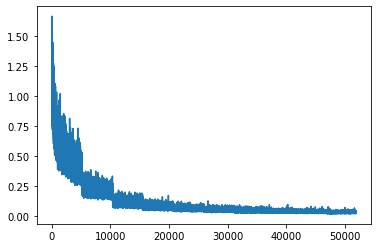

In [20]:
plt.plot(loss_values)

/home/tensor/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/tensor/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


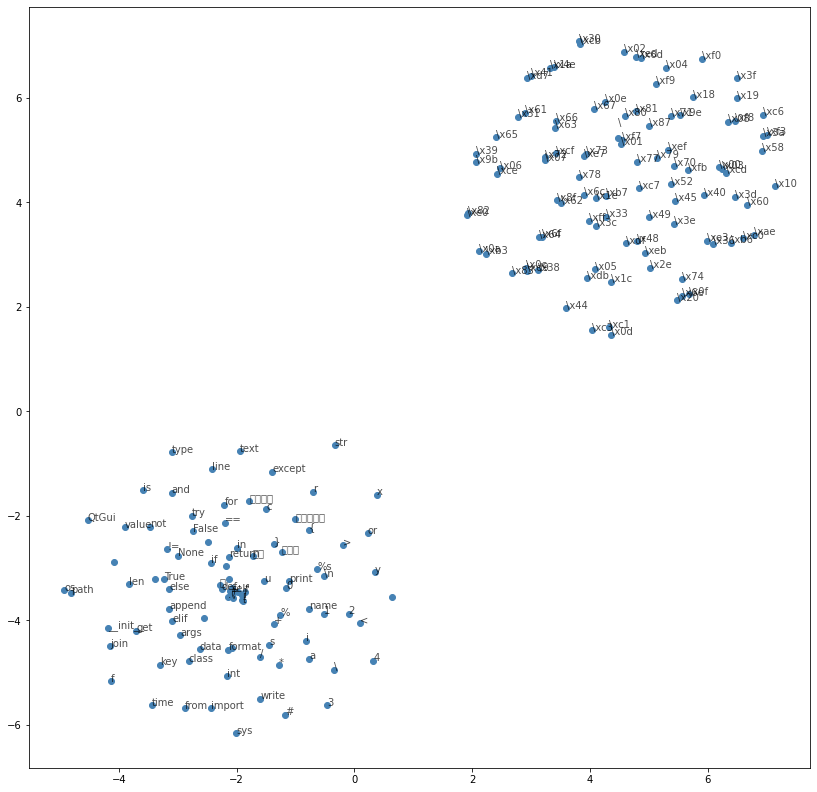

In [21]:
emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
emb = emb_i + emb_j
top_k = 200
tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(emb[:top_k, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(dataset._id2word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)


In [22]:
# loading the embedding weight
embedding_corpus = glove.wi.weight.cpu().data.numpy()
# to query word and id
# word2id = {w:i for i,w in enumerate(python_corpus_tokens)}
# id2word = {i:w for w, i in word2id.items()}
word2id ,id2word , processed_corpus_used_for_training =  dataset.get_vocab_info()

# dump the word2emb pickle
word2emb = {}
for word in tqdm(word2id):
  word2emb[word] = embedding_corpus[word2id[word]]

with open('./pygments_glove_embedding.pkl' , 'wb') as f:
  pickle.dump(word2emb,f)

100%|██████████| 667631/667631 [00:00<00:00, 1680057.37it/s]


In [16]:
# np.sum(word2emb["if"] - word2emb["else"])

In [17]:
# word2id ,id2word , _ =  dataset.get_vocab_info()

In [18]:
# len(word2id)

In [19]:
# id2word[len(processed_corpus_used_for_training)]